In [1]:
import sys
sys.path.append('/home/labs/amit/noamsh/repos/MM_2023')

In [2]:
from pathlib import Path

from omegaconf import OmegaConf
import anndata as ad
import scanpy as sc

from sc_classification.train_test_split import split_adata

In [3]:
# load configuration
config_path = '/home/labs/amit/noamsh/repos/MM_2023/config.yaml'
conf = OmegaConf.load(config_path)

In [4]:
adata_path = Path(conf.outputs.output_dir, conf.outputs.processed_adata_file_name)
adata = ad.read_h5ad(adata_path)

In [5]:
# drop LowQ cells from annotations
num_cells_before_drop = len(adata.obs)
adata = adata[adata.obs[conf.annotation.cell_type_columns] != "LowQ"]
num_cells_after_drop = len(adata.obs)
number_of_cells_droped = num_cells_before_drop - num_cells_after_drop
print(f"before: {num_cells_before_drop}, after: {num_cells_after_drop}, droped: {number_of_cells_droped} cells")

before: 276268, after: 130257, droped: 146011 cells


In [6]:
sc.pp.normalize_total(adata, target_sum=1e4)
sc.pp.log1p(adata)

Received a view of an AnnData. Making a copy.


In [7]:
# sc.pp.regress_out(adata, ['total_counts', 'pct_counts_mt'])
# sc.pp.scale(adata, max_value=10)

In [8]:
adata_train, adata_test = split_adata(adata, split_by_obs_column=conf.annotation.patient_id_column_name)

## gene selection


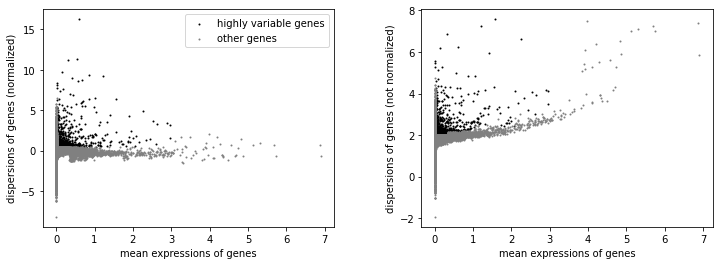

View of AnnData object with n_obs × n_vars = 130257 × 49658
    obs: 'Amp.Batch.ID', 'Seq.Batch.ID', 'Batch.Set.ID', 'Member', 'Description', 'Included', 'Tissue', 'Gating', 'Total.PC', 'Total.NonPC', 'Initial.Code', 'Disease', 'Project', 'Cohort', 'Weizmann.Code', 'Hospital.Code', 'Unnamed: 0', 'type', 'amp_batch_id', 'seq_batch_id', 'batch_set_id', 'Member_annotation', 'Description_annotation', 'Included_annotation', 'Tissue_annotation', 'Gating_annotation', 'Total.PC_annotation', 'Total.NonPC_annotation', 'Initial.Code_annotation', 'Disease_annotation', 'Project_annotation', 'Cohort_annotation', 'Weizmann.Code_annotation', 'Hospital.Code_annotation', 'spike_count', 'Annotation', 'n_genes', 'n_counts', 'n_genes_by_counts', 'total_counts', 'total_counts_mt', 'pct_counts_mt', 'train'
    var: 'n_cells', 'mt', 'n_cells_by_counts', 'mean_counts', 'pct_dropout_by_counts', 'total_counts'
    uns: 'log1p'

In [9]:
from pre_processing.black_list import drop_blacklist_genes_by_prefix

sc.pp.highly_variable_genes(adata_train, min_mean=0.0125, max_mean=3, min_disp=0.5)
# sc.pp.highly_variable_genes( adata, n_top_genes=1200, subset=True, flavor="seurat_v3")
sc.pl.highly_variable_genes(adata_train)
drop_blacklist_genes_by_prefix(adata, conf.sc_classification.gene_selection_prefix_blacklist)

In [10]:
adata_train.raw = adata_train
adata_test.raw = adata_test

In [11]:
adata_train = adata_train[:, adata_train.var.highly_variable]
var_names = adata_train.var_names.intersection(adata_test.var_names)

adata_train = adata_train[:, var_names]
adata_test = adata_test[:, var_names]

In [12]:
## building neighborhood graph

In [13]:
sc.pp.pca(adata_train)
sc.pp.neighbors(adata_train, n_neighbors=5)
sc.tl.umap(adata_train)

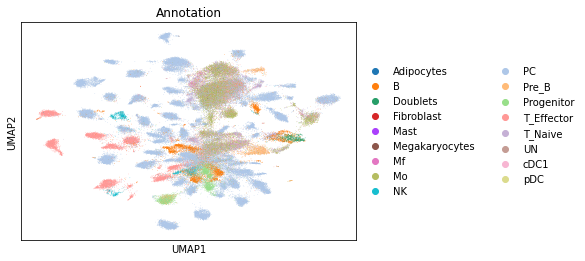

In [14]:
sc.pl.umap(adata_train, color=conf.annotation.cell_type_columns)

In [15]:
# ingest - PC vs other

In [16]:
adata_train.obs["is_pc"] = adata_train.obs[conf.annotation.cell_type_columns] == "PC"

In [17]:
sc.tl.ingest(adata_test, adata_ref=adata_train, obs='is_pc')

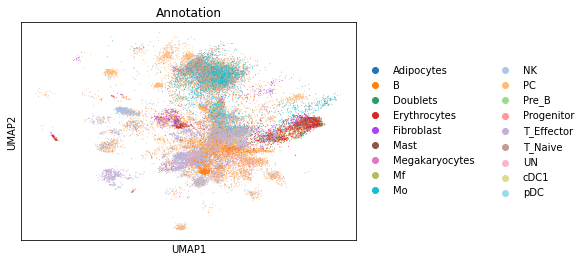

In [18]:
sc.pl.umap(adata_test, wspace=0.5, color=conf.annotation.cell_type_columns)

In [19]:
# evaluation

In [20]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt
y_true =  adata_test.obs[conf.annotation.cell_type_columns] == "PC"
y_pred = adata_test.obs["is_pc"]

cm = confusion_matrix(y_true=list(y_true), y_pred=list(y_pred))
disp = ConfusionMatrixDisplay(confusion_matrix=cm)

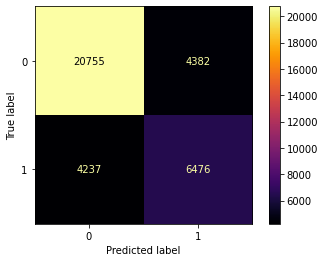

In [21]:
disp.plot(cmap="inferno")
plt.show()

In [22]:
## I will do this in a more orgenized manner later
## scvi representation
import scvi

In [23]:
# TODO I NEED TO un-normelize the data
scvi.data.setup_anndata(adata_train)

INFO     No batch_key inputted, assuming all cells are same batch                            
INFO     No label_key inputted, assuming all cells have same label                           
INFO     Using data from adata.X                                                             
INFO     Computing library size prior per batch                                              
INFO     Successfully registered anndata object containing 94407 cells, 3241 vars, 1 batches,
         1 labels, and 0 proteins. Also registered 0 extra categorical covariates and 0 extra
         continuous covariates.                                                              
INFO     Please do not further modify adata until model is trained.                          


In [24]:
model = scvi.model.SCVI(adata_train)
model

Make sure the registered X field in anndata contains unnormalized count data.


SCVI Model with the following params: 
n_hidden: 128, n_latent: 10, n_layers: 1, dropout_rate: 0.1, dispersion: gene, 
gene_likelihood: zinb, latent_distribution: normal
Training status: Not Trained

To print summary of associated AnnData, use: scvi.data.view_anndata_setup(model.adata)

In [25]:
model.train()

GPU available: False, used: False
TPU available: False, using: 0 TPU cores


Epoch 1/85:   0%|          | 0/85 [00:00<?, ?it/s]

The value argument must be within the support of the distribution


Epoch 13/85:  14%|█▍        | 12/85 [05:20<32:23, 26.63s/it, loss=487, v_num=1]

Detected KeyboardInterrupt, attempting graceful shutdown...


In [26]:
adata_train.obsm["X_scVI"] = model.get_latent_representation()
sc.pp.neighbors(adata_train, use_rep="X_scVI", n_neighbors=5)
sc.tl.umap(adata_train, min_dist=0.2)

Make sure the registered X field in anndata contains unnormalized count data.


KeyboardInterrupt: 

In [ ]:
adata_train.obs["is_pc"] = adata_train.obs[conf.annotation.cell_type_columns] == "PC"
sc.tl.ingest(adata_test, adata_train, obs='is_pc')
sc.pl.umap(adata_test, wspace=0.5, color=conf.annotation.cell_type_columns)

In [ ]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt
y_true =  adata_test.obs[conf.annotation.cell_type_columns] == "PC"
y_pred = adata_test.obs["is_pc"]

cm = confusion_matrix(y_true=list(y_true), y_pred=list(y_pred))
disp = ConfusionMatrixDisplay(confusion_matrix=cm)

In [ ]:
disp.plot(cmap="inferno")
plt.show()